# Classification Problem
This notebook will try to solve direction classification problem.
The Data phone sensors acceleration & gyroscope
The Target we will try to find the direction the phone moved - up, down, left, right, up left, up right, down left, down right 

In [10]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, load_model
from keras.layers import Input, LSTM, Dense, Dropout, LeakyReLU, Reshape, Bidirectional, LSTM, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import concatenate, Conv1D, BatchNormalization, Flatten, Multiply, Concatenate, Add, Subtract, Dot, Lambda, PReLU, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor

In [11]:
BATCH_SIZE = 32
EPOCKS = 50

# Loading the data

In [12]:
def load_data():
    path = '../input/generations'
    gens = None
    paths = os.listdir(path)
    for p in paths:
        gen = pd.read_csv(path + '/' +p)
        if gens is None:
            gens = gen
        else:
            gens = pd.concat([gens, gen])
    return gens

gens = load_data()
gens.head()

,Unnamed: 0,tag,accelometer_x,accelometer_y,accelometer_z,gyroscope_x,gyroscope_y,gyroscope_z,speed
0,0,up,-0.457306,3.747040,9.706390,0.001173,-0.012273,0.005558,NaN
1,1,up,-0.629694,3.845205,9.775824,-0.000659,-0.004943,0.003725,NaN
2,2,up,0.881093,2.636096,9.806950,-0.006768,0.013994,0.072753,NaN
3,3,up,-0.766168,2.188367,9.696813,-0.004324,-0.001888,0.292053,NaN
4,4,up,-0.131685,1.106155,9.885961,-0.002492,-0.002499,0.283501,NaN


# Analyzing The data & Split to train and test sets

In [13]:
def analyze_tags(gens):
    tags = gens['tag'].unique()
    print('tags (', len(tags) ,'): ', tags)
    grouped = gens.groupby('tag').count()

analyze_tags(gens)

tags ( 8 ):  ['up' 'down' 'right' 'left' 'upright' 'downleft' 'upleft' 'downright']


In [14]:
def create_X_y(gens):
    X = gens.drop(['tag','speed','Unnamed: 0'], axis=1)
    y = gens['tag']
    return X, y

X, y = create_X_y(gens)

In [15]:
def split_train_test(X, y, precentage = 0.2):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=precentage)
    print('X train shape: ',X_train.shape, ' y train shape: ', y_train.shape)
    print('X test shape: ',X_test.shape, ' y test shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test

def y_to_categorical(y_train, y_test):
    dic = {x:i for i,x in enumerate(y_train.unique())}
    len_train = len(y_train)
    y = np.concatenate([y_train.to_numpy(), y_test.to_numpy()])
    y = [dic[x] for x in y]
    y = to_categorical(y)
    y_train = y[0:len_train]
    y_test = [dic[x] for x in y_test]
    print('Changed to catigorical','y train shape: ',len(y_train), ' y test shape: ', len(y_test))
    return y_train, y_test, dic

X_train, X_test, y_train, y_test = split_train_test(X, y)
y_train, y_test, y_dic = y_to_categorical(y_train, y_test)

X train shape:  (4739, 6)  y train shape:  (4739,)
X test shape:  (1185, 6)  y test shape:  (1185,)
Changed to catigorical y train shape:  4739  y test shape:  1185


In [16]:
def split_train_test_by_tag(gens, precentage = 0.2):
    grouped = gens.groupby('tag')
    X_train = None
    X_test = None
    y_train = None
    y_test = None
    for g in grouped:
        X, y = create_X_y(g[1])
        X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp = train_test_split(X, y)
        if X_train is None:
            X_train, X_test, y_train, y_test = X_train_tmp, X_test_tmp, y_train_tmp, y_test_tmp 
        else:
            X_train = pd.concat([X_train, X_train_tmp])
            y_train = pd.concat([y_train, y_train_tmp])
            X_test = pd.concat([X_test, X_test_tmp])
            y_test = pd.concat([y_test, y_test_tmp])
    print('X grouped train shape: ',X_train.shape, ' y grouped train shape: ', y_train.shape)
    print('X grouped test shape: ',X_test.shape, ' y grouped test shape: ', y_test.shape)
    return X_train, X_test, y_train, y_test


X_train_g, X_test_g, y_train_g, y_test_g = split_train_test_by_tag(gens)
y_train_g, y_test_g, y_dic_g = y_to_categorical(y_train_g, y_test_g)

X grouped train shape:  (4441, 6)  y grouped train shape:  (4441,)
X grouped test shape:  (1483, 6)  y grouped test shape:  (1483,)
Changed to catigorical y train shape:  4441  y test shape:  1483


In [17]:
def split_train_test_by_subtruction_close_points(X,y):
    grouped = gens.groupby('tag')
    X_tmp = None
    y_tmp = None
    X_original = None
    for g in grouped:
        X, y = create_X_y(g[1])
        tmp_dic = {}
        if X_original is None:
            X_original = X.iloc[1:]
        else:
            X_original = pd.concat([X_original,X.iloc[1:]])
        for col in X.columns:
            #tmp_dic['sub_'+col] = X[col].iloc[1:].values - X[col].iloc[:len(X)-1].values
            tmp_dic['sub_'+col] = X[col].iloc[:len(X)-1].values
        if X_tmp is None:
            X_tmp = pd.DataFrame.from_dict(tmp_dic)
            y_tmp = y.iloc[:len(X)-1]
        else:
            X_tmp = pd.concat([X_tmp, pd.DataFrame.from_dict(tmp_dic)])
            y_tmp = pd.concat([y_tmp, y.iloc[1:]])
    X_original = X_original.reset_index()
    X_tmp = X_tmp.reset_index()
    X_tmp = pd.concat([X_tmp, X_original], axis=1)
    X_tmp = X_tmp.drop(['index'], axis=1)
    print('X subtract: ',X_tmp.shape, ' y substract: ', y_tmp.shape)
    X_train, X_test, y_train, y_test = split_train_test(X_tmp, y_tmp)
    return X_train, X_test, y_train, y_test

X_train_s, X_test_s, y_train_s, y_test_s = split_train_test_by_subtruction_close_points(X, y)
y_train_s, y_test_s, y_dic_s = y_to_categorical(y_train_s, y_test_s)

X subtract:  (5916, 12)  y substract:  (5916,)
X train shape:  (4732, 12)  y train shape:  (4732,)
X test shape:  (1184, 12)  y test shape:  (1184,)
Changed to catigorical y train shape:  4732  y test shape:  1184


In [171]:
def split_train_test_by_sliding_window(X,y, N=2):
    grouped = gens.groupby('tag')
    X_tmp = None
    X_original = None
    y_original = None
    start = N
    end = None
    for g in grouped:
        X, y = create_X_y(g[1])
        end = len(X)
        tmp_dic = {}
        if X_original is None:
            X_original = X.iloc[start:]
            y_original = y.iloc[start:]
        else:
            X_original = pd.concat([X_original,X.iloc[start:]])
            y_original = pd.concat([y_original, y.iloc[start:]])
        for col in X.columns:
            for i in range(1,N,1):
                name = 'prev_'+str(i)+'_'+col
                tmp_dic[name] = X[col].iloc[start-i: end-i].values
        if X_tmp is None:
            X_tmp = pd.DataFrame.from_dict(tmp_dic)
        else:
            X_tmp = pd.concat([X_tmp, pd.DataFrame.from_dict(tmp_dic)])
    X_original = X_original.reset_index()
    X_tmp = X_tmp.reset_index()
    X_tmp = pd.concat([X_tmp, X_original], axis=1)
    X_tmp = X_tmp.drop(['index'], axis=1)
    print('X devide: ',X_tmp.shape, ' y devide: ', y_original.shape)
    X_train, X_test, y_train, y_test = split_train_test(X_tmp, y_original)
    return X_train, X_test, y_train, y_test

X_train_d, X_test_d, y_train_d, y_test_d = split_train_test_by_sliding_window(X, y)
y_train_d, y_test_d, y_dic_d = y_to_categorical(y_train_d, y_test_d)
print('nan indexes',np.where(pd.isnull(X_train_d)))

X devide:  (5908, 12)  y devide:  (5908,)
X train shape:  (4726, 12)  y train shape:  (4726,)
X test shape:  (1182, 12)  y test shape:  (1182,)
Changed to catigorical y train shape:  4726  y test shape:  1182
nan indexes (array([], dtype=int64), array([], dtype=int64))


# Creating Classification Naive Model 

In [19]:
def create_callbacks(name, patience=5):
    early_stopping = EarlyStopping(patience=patience)
    cheak_point = ModelCheckpoint(name)
    return [early_stopping, cheak_point]

def create_metrics():
    return ['accuracy']

def create_model1(size=6):
    inp = Input(shape=(None,size))
    x = Dense(32, activation='relu')(inp)
    x = Dense(64, activation='relu')(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model1') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model1 = create_model1()
callbacks = create_callbacks('model1.h5')
history = model1.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.15, callbacks=callbacks)

Epoch 1/50
126/126 [==============================] - 0s 4ms/step - loss: 2.1184 - accuracy: 0.1487 - val_loss: 2.0093 - val_accuracy: 0.2152
Epoch 2/50
126/126 [==============================] - 0s 2ms/step - loss: 1.9744 - accuracy: 0.2500 - val_loss: 1.9109 - val_accuracy: 0.3136
Epoch 3/50
126/126 [==============================] - 0s 2ms/step - loss: 1.8260 - accuracy: 0.3414 - val_loss: 1.7519 - val_accuracy: 0.3840
Epoch 4/50
126/126 [==============================] - 0s 2ms/step - loss: 1.6739 - accuracy: 0.3731 - val_loss: 1.6557 - val_accuracy: 0.3699
Epoch 5/50
126/126 [==============================] - 0s 2ms/step - loss: 1.5830 - accuracy: 0.3937 - val_loss: 1.5961 - val_accuracy: 0.3713
Epoch 6/50
126/126 [==============================] - 0s 2ms/step - loss: 1.5411 - accuracy: 0.3888 - val_loss: 1.5832 - val_accuracy: 0.3868
Epoch 7/50
126/126 [==============================] - 0s 2ms/step - loss: 1.5084 - accuracy: 0.4121 - val_loss: 1.5717 - val_accuracy: 0.4065
Epoch 

## X,y not grouped 

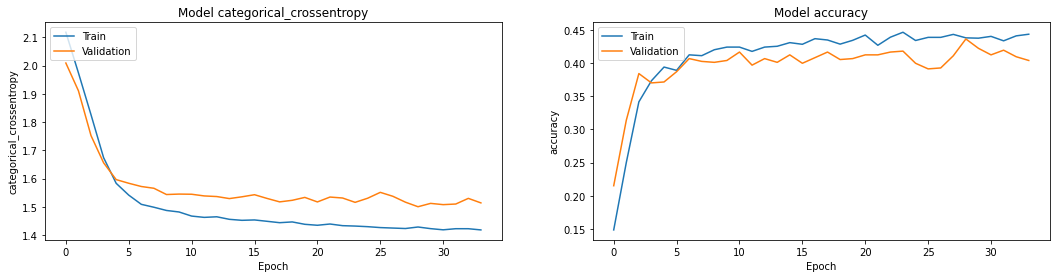

In [20]:
def quick_plot_loss(history, field, metric, ax):
    # Plot training & validation loss values
    ax.plot(history.history[field])
    ax.plot(history.history['val_'+field])
    ax.set_title('Model '+ metric)
    ax.set_ylabel(metric)
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')
                
    
def quick_plot_history(history):
    fig = plt.figure(figsize=(18, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.set_title('loss')
    quick_plot_loss(history, 'loss', 'categorical_crossentropy', ax)
    ax = fig.add_subplot(1, 2, 2)
    ax.set_title('accrucy')
    quick_plot_loss(history, 'accuracy', 'accuracy', ax)
    
quick_plot_history(history)

In [21]:
def test_results(model,X_test,y_test, LOAD=True):
    preds = model.predict(X_test)
    pred_cat = np.argmax(preds,axis=1) #takes the maximum prediction and compare it to the real prediction
    acc = accuracy_score(y_test,pred_cat)*100
    acc_saved = -1
    if LOAD:
        saved_model = load_model('./'+model.name+'.h5')
        preds = saved_model.predict(X_test)
        pred_cat = np.argmax(preds,axis=1) #takes the maximum prediction and compare it to the real prediction
        acc_saved = accuracy_score(y_test,pred_cat)*100
    
    if acc > acc_saved:
        if LOAD:
            model.save('./'+model.name+'.h5')
        print('NEW: model accuracy on test set is: {0:.2f}%'.format(acc))
    else:
        print('model accuracy on test set is: {0:.2f}%'.format(acc_saved))

test_results(model1, X_test, y_test)

model accuracy on test set is: 42.53%


## X,y grouped 

In [22]:
model1_grouped = create_model1()
callbacks = create_callbacks('model1_grouped.h5')
history = model1_grouped.fit(X_train_g, y_train_g, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.15)

Epoch 1/50
118/118 [==============================] - 0s 2ms/step - loss: 2.0085 - accuracy: 0.1635 - val_loss: 5.6113 - val_accuracy: 0.0000e+00
Epoch 2/50
118/118 [==============================] - 0s 2ms/step - loss: 1.8351 - accuracy: 0.2949 - val_loss: 6.3225 - val_accuracy: 0.0000e+00
Epoch 3/50
118/118 [==============================] - 0s 2ms/step - loss: 1.7245 - accuracy: 0.3482 - val_loss: 6.9743 - val_accuracy: 0.0060
Epoch 4/50
118/118 [==============================] - 0s 2ms/step - loss: 1.6002 - accuracy: 0.3810 - val_loss: 7.4084 - val_accuracy: 0.0270
Epoch 5/50
118/118 [==============================] - 0s 2ms/step - loss: 1.4935 - accuracy: 0.4213 - val_loss: 8.0712 - val_accuracy: 0.0690
Epoch 6/50
118/118 [==============================] - 0s 2ms/step - loss: 1.4293 - accuracy: 0.4433 - val_loss: 8.5485 - val_accuracy: 0.0525
Epoch 7/50
118/118 [==============================] - 0s 2ms/step - loss: 1.3872 - accuracy: 0.4542 - val_loss: 8.8916 - val_accuracy: 0.060

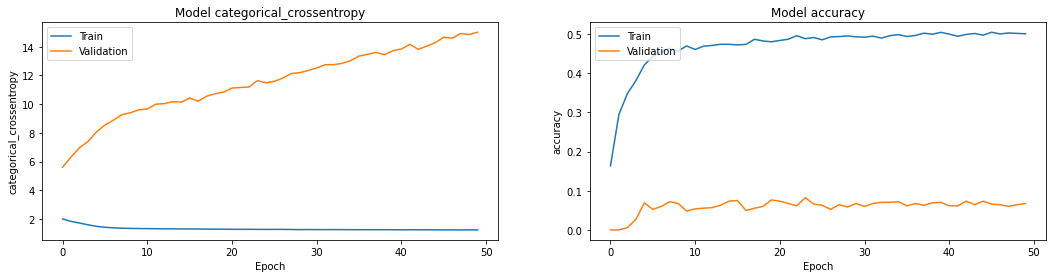

In [23]:
quick_plot_history(history)

It's seems for the naive model The random split is much better then the group split, The group split made the model to be overfitting.

# Improvments - Building More complex models
* model2 - added Droupout
* model3 - added more nyrones to model 2
* model4 - change the model architecture, added another dense moved the dropout to be the last, changed the first activation to tanh
* model5 - change the model architecture to support LSTM, added Reshape
* model6 - addeed more complexity model5

# Model 2

In [24]:
def dense_block(inp, n=32):
    x = Dense(n, activation='relu')(inp)
    x = Dense(n*2, activation='relu')(x)
    return x

def create_model2(size=6):
    inp = Input(shape=(None,size))
    x = dense_block(inp)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model2') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model2 = create_model2()
callbacks = create_callbacks('model2.h5')
history = model2.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.15, callbacks=callbacks)

Epoch 1/50
126/126 [==============================] - 1s 4ms/step - loss: 2.1929 - accuracy: 0.1398 - val_loss: 2.0300 - val_accuracy: 0.2293
Epoch 2/50
126/126 [==============================] - 0s 2ms/step - loss: 2.0238 - accuracy: 0.1904 - val_loss: 1.9855 - val_accuracy: 0.2574
Epoch 3/50
126/126 [==============================] - 0s 2ms/step - loss: 1.9510 - accuracy: 0.2468 - val_loss: 1.8933 - val_accuracy: 0.3094
Epoch 4/50
126/126 [==============================] - 0s 2ms/step - loss: 1.8688 - accuracy: 0.2937 - val_loss: 1.8194 - val_accuracy: 0.3277
Epoch 5/50
126/126 [==============================] - 0s 2ms/step - loss: 1.7937 - accuracy: 0.3294 - val_loss: 1.7487 - val_accuracy: 0.3122
Epoch 6/50
126/126 [==============================] - 0s 2ms/step - loss: 1.7332 - accuracy: 0.3396 - val_loss: 1.6752 - val_accuracy: 0.3952
Epoch 7/50
126/126 [==============================] - 0s 2ms/step - loss: 1.6794 - accuracy: 0.3689 - val_loss: 1.6364 - val_accuracy: 0.3882
Epoch 

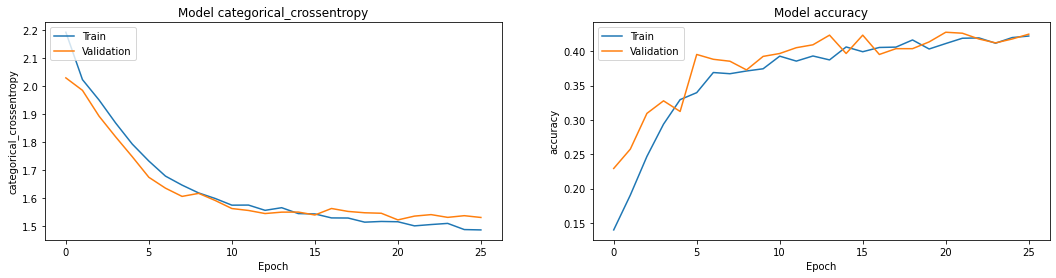

In [25]:
quick_plot_history(history)

In [26]:
test_results(model2, X_test, y_test)

model accuracy on test set is: 44.64%


It seems only adding a dropout improved the results on the test set from the naive model.

# Model 3

In [27]:
def create_model3(size=6):
    inp = Input(shape=(None,size))
    x = dense_block(inp, n=64)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model3') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model3 = create_model3()
callbacks = create_callbacks('model3.h5')
history = model3.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.15, callbacks=callbacks)

Epoch 1/50
126/126 [==============================] - 0s 3ms/step - loss: 2.1247 - accuracy: 0.1614 - val_loss: 1.9719 - val_accuracy: 0.2616
Epoch 2/50
126/126 [==============================] - 0s 2ms/step - loss: 1.9071 - accuracy: 0.2743 - val_loss: 1.8059 - val_accuracy: 0.3432
Epoch 3/50
126/126 [==============================] - 0s 2ms/step - loss: 1.7224 - accuracy: 0.3451 - val_loss: 1.6516 - val_accuracy: 0.3840
Epoch 4/50
126/126 [==============================] - 0s 2ms/step - loss: 1.6114 - accuracy: 0.3764 - val_loss: 1.6046 - val_accuracy: 0.3896
Epoch 5/50
126/126 [==============================] - 0s 2ms/step - loss: 1.5716 - accuracy: 0.3846 - val_loss: 1.5860 - val_accuracy: 0.3741
Epoch 6/50
126/126 [==============================] - 0s 2ms/step - loss: 1.5396 - accuracy: 0.3955 - val_loss: 1.5570 - val_accuracy: 0.4051
Epoch 7/50
126/126 [==============================] - 0s 2ms/step - loss: 1.5244 - accuracy: 0.3972 - val_loss: 1.5727 - val_accuracy: 0.3910
Epoch 

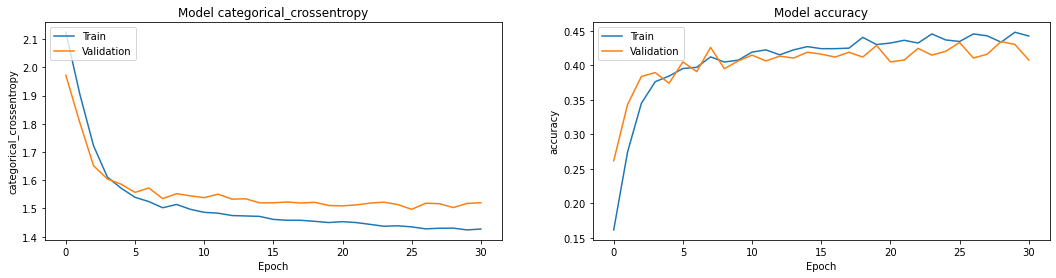

In [28]:
quick_plot_history(history)

In [29]:
test_results(model3, X_test, y_test)

model accuracy on test set is: 45.32%


# Model 4

In [30]:
def create_model4(size=6):
    inp = Input(shape=(None,size))
    x = Dense(16, activation='tanh')(inp)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dropout(0.2)(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model4') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model4 = create_model4()
callbacks = create_callbacks('model4.h5')
history = model4.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 0s 3ms/step - loss: 2.0727 - accuracy: 0.1614 - val_loss: 2.0271 - val_accuracy: 0.2004
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 1.9791 - accuracy: 0.2290 - val_loss: 1.9146 - val_accuracy: 0.2975
Epoch 3/50
119/119 [==============================] - 0s 2ms/step - loss: 1.8276 - accuracy: 0.3092 - val_loss: 1.7444 - val_accuracy: 0.3639
Epoch 4/50
119/119 [==============================] - 0s 2ms/step - loss: 1.6627 - accuracy: 0.3498 - val_loss: 1.5945 - val_accuracy: 0.3861
Epoch 5/50
119/119 [==============================] - 0s 2ms/step - loss: 1.5854 - accuracy: 0.3748 - val_loss: 1.5627 - val_accuracy: 0.3966
Epoch 6/50
119/119 [==============================] - 0s 2ms/step - loss: 1.5451 - accuracy: 0.3912 - val_loss: 1.5340 - val_accuracy: 0.4124
Epoch 7/50
119/119 [==============================] - 0s 2ms/step - loss: 1.5310 - accuracy: 0.3954 - val_loss: 1.5309 - val_accuracy: 0.3998
Epoch 

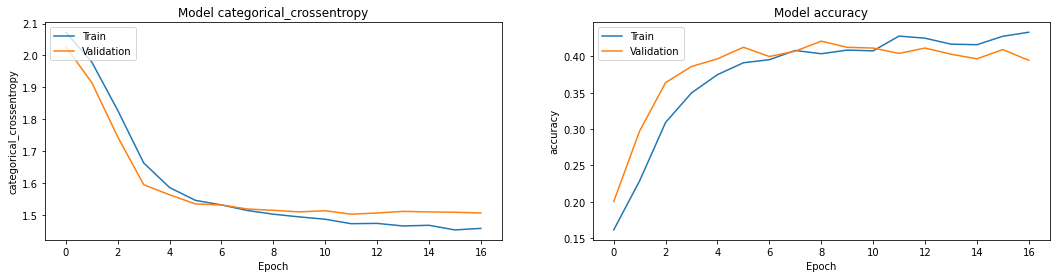

In [31]:
quick_plot_history(history)

In [32]:
test_results(model4, X_test, y_test)

model accuracy on test set is: 44.98%


# Model 5

In [33]:
def create_model5(size=6):
    inp = Input(shape=(None,size))
    x = Dense(256, activation='tanh')(inp)
    x = Reshape([4,64])(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = Bidirectional(LSTM(16))(x)
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model5') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model5 = create_model5()
callbacks = create_callbacks('model5.h5')
history = model5.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 1s 12ms/step - loss: 1.8573 - accuracy: 0.2875 - val_loss: 1.6255 - val_accuracy: 0.3650
Epoch 2/50
119/119 [==============================] - 1s 5ms/step - loss: 1.5516 - accuracy: 0.3827 - val_loss: 1.5716 - val_accuracy: 0.3660
Epoch 3/50
119/119 [==============================] - 1s 5ms/step - loss: 1.5067 - accuracy: 0.4126 - val_loss: 1.5291 - val_accuracy: 0.4072
Epoch 4/50
119/119 [==============================] - 1s 5ms/step - loss: 1.4815 - accuracy: 0.4123 - val_loss: 1.5244 - val_accuracy: 0.4040
Epoch 5/50
119/119 [==============================] - 1s 6ms/step - loss: 1.4645 - accuracy: 0.4221 - val_loss: 1.5358 - val_accuracy: 0.4114
Epoch 6/50
119/119 [==============================] - 1s 5ms/step - loss: 1.4697 - accuracy: 0.4210 - val_loss: 1.5099 - val_accuracy: 0.4135
Epoch 7/50
119/119 [==============================] - 1s 6ms/step - loss: 1.4514 - accuracy: 0.4257 - val_loss: 1.5237 - val_accuracy: 0.4209
Epoch

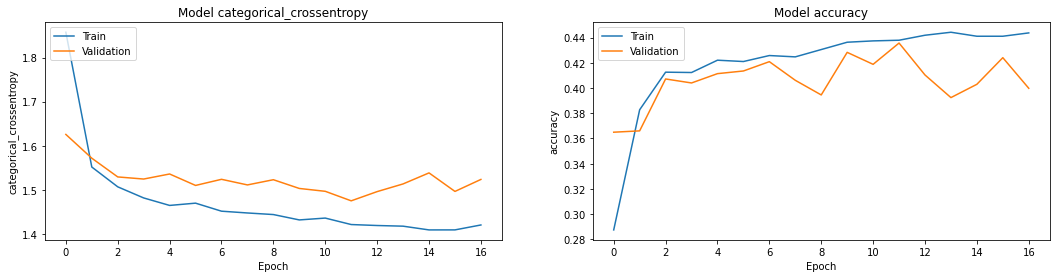

In [34]:
quick_plot_history(history)

In [35]:
test_results(model5, X_test, y_test)

model accuracy on test set is: 41.60%


# Model 6

In [36]:
def create_model6(size=6):
    inp = Input(shape=(None,size))
    x = Dense(1024, activation='tanh')(inp)
    x = Reshape([16,64])(x)
    x = BatchNormalization(momentum=0.5)(x)
    x1 = Bidirectional(LSTM(64))(x)
    x1 = Flatten()(x1)
    x2 = GlobalAveragePooling1D()(x)
    x3 = GlobalMaxPooling1D()(x)
    x = concatenate([x1,x2,x3])
    x = Dense(256, activation='relu')(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model6') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model6 = create_model6()
callbacks = create_callbacks('model6.h5')
history = model6.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 3s 22ms/step - loss: 2.0239 - accuracy: 0.2087 - val_loss: 1.7750 - val_accuracy: 0.3259
Epoch 2/50
119/119 [==============================] - 2s 15ms/step - loss: 1.6192 - accuracy: 0.3622 - val_loss: 1.6225 - val_accuracy: 0.3755
Epoch 3/50
119/119 [==============================] - 2s 15ms/step - loss: 1.5110 - accuracy: 0.4031 - val_loss: 1.5660 - val_accuracy: 0.3966
Epoch 4/50
119/119 [==============================] - 2s 15ms/step - loss: 1.4922 - accuracy: 0.4036 - val_loss: 1.5655 - val_accuracy: 0.4008
Epoch 5/50
119/119 [==============================] - 2s 15ms/step - loss: 1.4874 - accuracy: 0.4094 - val_loss: 1.5598 - val_accuracy: 0.3892
Epoch 6/50
119/119 [==============================] - 2s 15ms/step - loss: 1.4626 - accuracy: 0.4210 - val_loss: 1.5391 - val_accuracy: 0.3882
Epoch 7/50
119/119 [==============================] - 2s 16ms/step - loss: 1.4597 - accuracy: 0.4207 - val_loss: 1.5641 - val_accuracy: 0.3734

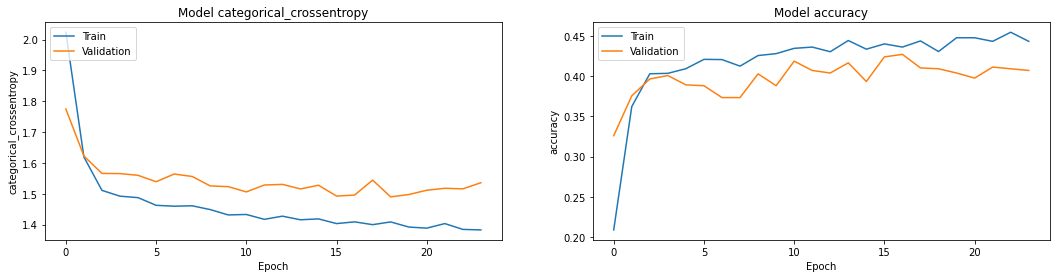

In [37]:
quick_plot_history(history)

In [38]:
test_results(model6, X_test, y_test)

model accuracy on test set is: 45.57%


# Model 7

In [39]:
def cov_blocks(inp, n, k):
    x = Conv1D(n, kernel_size=k, padding='same', activation='relu')(inp)
    x = Conv1D(n*2, kernel_size=k, padding='same', activation='relu')(x)
    x = Conv1D(n*3, kernel_size=k, padding='same', activation='relu')(x)
    x = Conv1D(n*4, kernel_size=k, padding='same', activation='relu')(x)
    x = Conv1D(n*5, kernel_size=k, padding='same', activation='relu')(x)
    x = Flatten()(x)
    return x

def create_model7(size=6):
    inp = Input(shape=(None,size))
    x = Dense(256, activation='tanh')(inp)
    x = Reshape([16,16])(x)
    x1 = cov_blocks(x, 16, 3)
    x2 = cov_blocks(x, 16, 4)
    x3 = cov_blocks(x, 16, 5)
    x = concatenate([x1,x2,x3])
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=inp, outputs=x, name='model7') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model7 = create_model7()
callbacks = create_callbacks('model7.h5')
history = model7.fit(X_train, y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 2s 18ms/step - loss: 1.9555 - accuracy: 0.2298 - val_loss: 1.7092 - val_accuracy: 0.3080
Epoch 2/50
119/119 [==============================] - 2s 14ms/step - loss: 1.5754 - accuracy: 0.3690 - val_loss: 1.5638 - val_accuracy: 0.3892
Epoch 3/50
119/119 [==============================] - 2s 17ms/step - loss: 1.5081 - accuracy: 0.4054 - val_loss: 1.5280 - val_accuracy: 0.3882
Epoch 4/50
119/119 [==============================] - 2s 13ms/step - loss: 1.4781 - accuracy: 0.4126 - val_loss: 1.5218 - val_accuracy: 0.4061
Epoch 5/50
119/119 [==============================] - 2s 13ms/step - loss: 1.4558 - accuracy: 0.4097 - val_loss: 1.5482 - val_accuracy: 0.3956
Epoch 6/50
119/119 [==============================] - 2s 13ms/step - loss: 1.4535 - accuracy: 0.4323 - val_loss: 1.5302 - val_accuracy: 0.4019
Epoch 7/50
119/119 [==============================] - 2s 14ms/step - loss: 1.4439 - accuracy: 0.4284 - val_loss: 1.5002 - val_accuracy: 0.4241

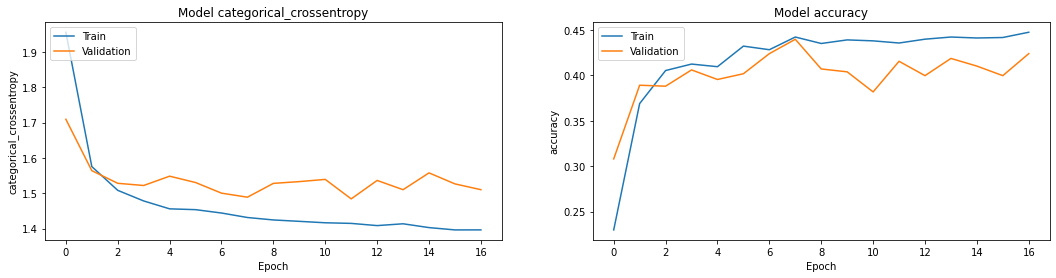

In [40]:
quick_plot_history(history)

In [41]:
test_results(model7, X_test, y_test)

model accuracy on test set is: 44.98%


## we will try creating a semaic model

# Model 8

In [42]:
# Multiply, Concatenate, Add, Subtract
def seimaic(size=3):
    inp = Input(shape=size)
    x = Dense(16, activation='relu')(inp)
    x = Dense(32, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    return inp, x

def create_model_seamic1():
    inp1, s1 = seimaic()
    inp2, s2 = seimaic()
    x = concatenate([s1, s2])
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2], outputs=x, name='model8') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model8 = create_model_seamic1()

In [43]:
def split_semaic(X):
    A = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z'], axis=1)
    B = X.drop(['accelometer_x','accelometer_y','accelometer_z'], axis=1)
    return A, B

A, B = split_semaic(X_train)
callbacks = create_callbacks('model8.h5')
history = model8.fit([A,B], y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 0s 4ms/step - loss: 2.0290 - accuracy: 0.1965 - val_loss: 1.9553 - val_accuracy: 0.2711
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 1.8151 - accuracy: 0.3171 - val_loss: 1.7363 - val_accuracy: 0.3122
Epoch 3/50
119/119 [==============================] - 0s 2ms/step - loss: 1.5991 - accuracy: 0.4004 - val_loss: 1.5957 - val_accuracy: 0.3776
Epoch 4/50
119/119 [==============================] - 0s 2ms/step - loss: 1.4993 - accuracy: 0.4250 - val_loss: 1.5435 - val_accuracy: 0.4040
Epoch 5/50
119/119 [==============================] - 0s 2ms/step - loss: 1.4760 - accuracy: 0.4242 - val_loss: 1.5280 - val_accuracy: 0.4008
Epoch 6/50
119/119 [==============================] - 0s 2ms/step - loss: 1.4614 - accuracy: 0.4300 - val_loss: 1.5401 - val_accuracy: 0.3903
Epoch 7/50
119/119 [==============================] - 0s 2ms/step - loss: 1.4578 - accuracy: 0.4308 - val_loss: 1.5458 - val_accuracy: 0.3871
Epoch 

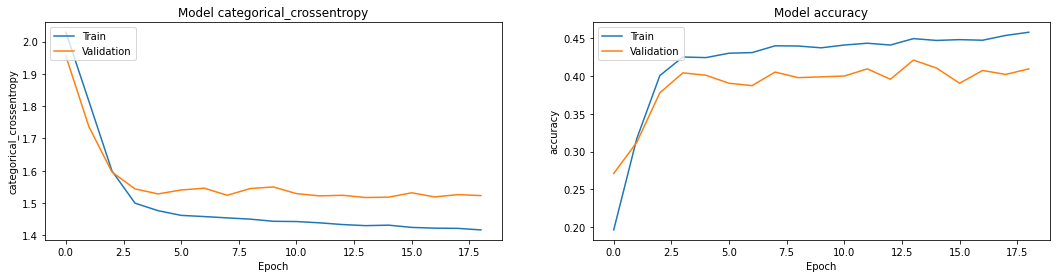

In [44]:
quick_plot_history(history)

In [45]:
A, B = split_semaic(X_test)
test_results(model8, [A,B], y_test)

model accuracy on test set is: 45.74%


# Model 9

In [46]:
def dense_deapth_block(inp, N=32, extend_N=4, deapth=5):
    if deapth==0:
        return inp
    x = None 
    prev_x = None
    xs = []
    for i in range(0, deapth):
        if x is None:
            x = Dense(N)(inp)
            x = PReLU()(x)
        else:
            prev_x = x
            x = Dense(N + i*extend_N)(prev_x)
            x = PReLU()(x)
        xs.append(x)
    if len(xs) != 1:
        x = concatenate(xs)
    return x

def seimaic2(size=3, deapth=5):
    inp = Input(shape=size)
    x = dense_deapth_block(inp, deapth=deapth)
    return inp, x

def create_model_seamic2():
    inp1, s1 = seimaic2(deapth=2)
    inp2, s2 = seimaic2()
    x = concatenate([s1, s2])
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2], outputs=x, name='model9') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model9 = create_model_seamic2()

In [47]:
A, B = split_semaic(X_train)
callbacks = create_callbacks('model9.h5')
history = model9.fit([A,B], y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 1s 5ms/step - loss: 2.0661 - accuracy: 0.1736 - val_loss: 1.9832 - val_accuracy: 0.1994
Epoch 2/50
119/119 [==============================] - 0s 3ms/step - loss: 1.9265 - accuracy: 0.2406 - val_loss: 1.9385 - val_accuracy: 0.2300
Epoch 3/50
119/119 [==============================] - 0s 3ms/step - loss: 1.8497 - accuracy: 0.2925 - val_loss: 1.8347 - val_accuracy: 0.3027
Epoch 4/50
119/119 [==============================] - 0s 3ms/step - loss: 1.7327 - accuracy: 0.3577 - val_loss: 1.7163 - val_accuracy: 0.3513
Epoch 5/50
119/119 [==============================] - 0s 3ms/step - loss: 1.6077 - accuracy: 0.3933 - val_loss: 1.6404 - val_accuracy: 0.3692
Epoch 6/50
119/119 [==============================] - 0s 3ms/step - loss: 1.5178 - accuracy: 0.4147 - val_loss: 1.5644 - val_accuracy: 0.3924
Epoch 7/50
119/119 [==============================] - 0s 3ms/step - loss: 1.4816 - accuracy: 0.4247 - val_loss: 1.5692 - val_accuracy: 0.3819
Epoch 

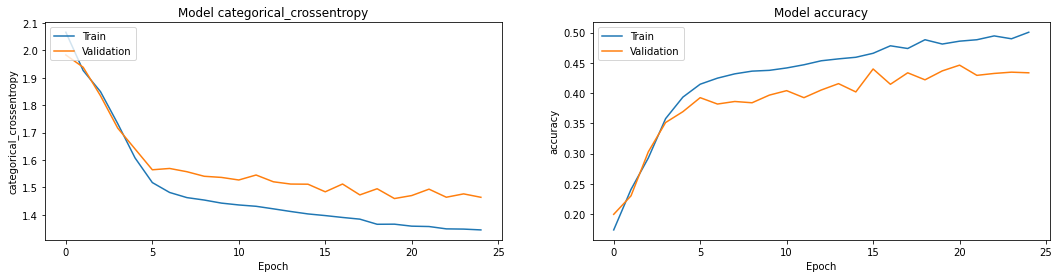

In [48]:
quick_plot_history(history)

In [49]:
A, B = split_semaic(X_test)
test_results(model9, [A,B], y_test)

model accuracy on test set is: 50.04%


# Creating a Bench Mark

In [50]:
forest = RandomForestRegressor(n_estimators = 100, max_depth = 8)
forest.fit(X_train,y_train)
test_results(forest, X_test, y_test, LOAD=False)

NEW: model accuracy on test set is: 49.28%


# Now that we pass the bench mark we will try to improve the model by extend the input model from 2 diffrent input chanels to 3,4,5 channels

# Model 10

In [51]:
def split_channels_3(X):
    A = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z'], axis=1)
    B = X.drop(['accelometer_x','accelometer_y','accelometer_z'], axis=1)
    C = X.copy()
    return A, B, C

def create_chanel(size=3, deapth=5, N=32,extend_N=4):
    inp = Input(shape=size)
    x = dense_deapth_block(inp, deapth=deapth, N=N, extend_N=extend_N)
    return inp, x

def create_model_channel_3():
    inp1, c1 = create_chanel(deapth=2,N=64)
    inp2, c2 = create_chanel(N=64)
    inp3, c3 = create_chanel(size=6,deapth=2, N=12)
    x = concatenate([c1, c2, c3])
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2, inp3], outputs=x, name='model10') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model10 = create_model_channel_3()

In [52]:
A, B, C = split_channels_3(X_train)
callbacks = create_callbacks('model10.h5')
history = model10.fit([A,B,C], y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 1s 6ms/step - loss: 2.0012 - accuracy: 0.2065 - val_loss: 1.9517 - val_accuracy: 0.2521
Epoch 2/50
119/119 [==============================] - 0s 4ms/step - loss: 1.8459 - accuracy: 0.3007 - val_loss: 1.8087 - val_accuracy: 0.2985
Epoch 3/50
119/119 [==============================] - 0s 4ms/step - loss: 1.6689 - accuracy: 0.3775 - val_loss: 1.6440 - val_accuracy: 0.3861
Epoch 4/50
119/119 [==============================] - 0s 4ms/step - loss: 1.5327 - accuracy: 0.4102 - val_loss: 1.5715 - val_accuracy: 0.3766
Epoch 5/50
119/119 [==============================] - 0s 4ms/step - loss: 1.4836 - accuracy: 0.4173 - val_loss: 1.5808 - val_accuracy: 0.3576
Epoch 6/50
119/119 [==============================] - 0s 4ms/step - loss: 1.4703 - accuracy: 0.4242 - val_loss: 1.5559 - val_accuracy: 0.3861
Epoch 7/50
119/119 [==============================] - 0s 4ms/step - loss: 1.4502 - accuracy: 0.4345 - val_loss: 1.5677 - val_accuracy: 0.3724
Epoch 

model accuracy on test set is: 50.04%


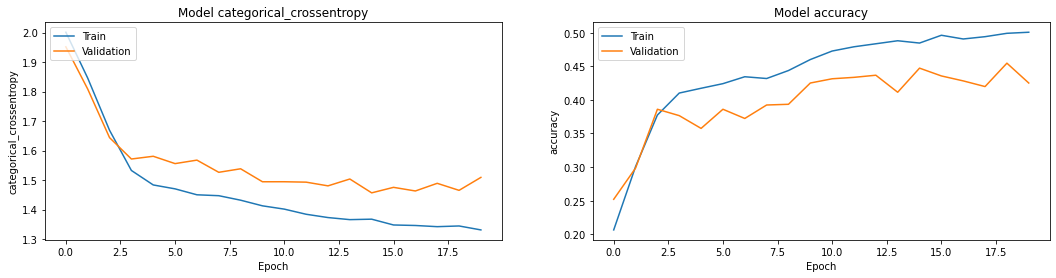

In [53]:
quick_plot_history(history)
A, B, C = split_channels_3(X_test)
test_results(model10, [A,B,C], y_test)

# Model 11

In [54]:
def split_channels_4(X):
    A = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z'], axis=1)
    B = X.drop(['accelometer_x','accelometer_y','accelometer_z'], axis=1)
    C = X.drop(['gyroscope_y','gyroscope_z','accelometer_y','accelometer_z'], axis=1)
    D = X.drop(['gyroscope_x','gyroscope_z','accelometer_x','accelometer_z'], axis=1)
    return A, B, C, D

def create_model_channel_4():
    inp1, c1 = create_chanel(deapth=2,N=64)
    inp2, c2 = create_chanel(N=64)
    inp3, c3 = create_chanel(size=2,deapth=2,N=12)
    inp4, c4 = create_chanel(size=2,deapth=2,N=12)
    x = concatenate([c1, c2, c3, c4])
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2, inp3, inp4], outputs=x, name='model11') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model11 = create_model_channel_4()

In [55]:
A, B, C, D = split_channels_4(X_train)
callbacks = create_callbacks('model11.h5')
history = model11.fit([A, B, C, D], y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 1s 6ms/step - loss: 1.9419 - accuracy: 0.2432 - val_loss: 1.8543 - val_accuracy: 0.2806
Epoch 2/50
119/119 [==============================] - 0s 4ms/step - loss: 1.6886 - accuracy: 0.3740 - val_loss: 1.6647 - val_accuracy: 0.3544
Epoch 3/50
119/119 [==============================] - 0s 4ms/step - loss: 1.5446 - accuracy: 0.4141 - val_loss: 1.5969 - val_accuracy: 0.3745
Epoch 4/50
119/119 [==============================] - 1s 4ms/step - loss: 1.4906 - accuracy: 0.4157 - val_loss: 1.5732 - val_accuracy: 0.3724
Epoch 5/50
119/119 [==============================] - 1s 4ms/step - loss: 1.4679 - accuracy: 0.4250 - val_loss: 1.5583 - val_accuracy: 0.3776
Epoch 6/50
119/119 [==============================] - 0s 4ms/step - loss: 1.4559 - accuracy: 0.4342 - val_loss: 1.5467 - val_accuracy: 0.3892
Epoch 7/50
119/119 [==============================] - 0s 4ms/step - loss: 1.4412 - accuracy: 0.4410 - val_loss: 1.5229 - val_accuracy: 0.3966
Epoch 

model accuracy on test set is: 50.21%


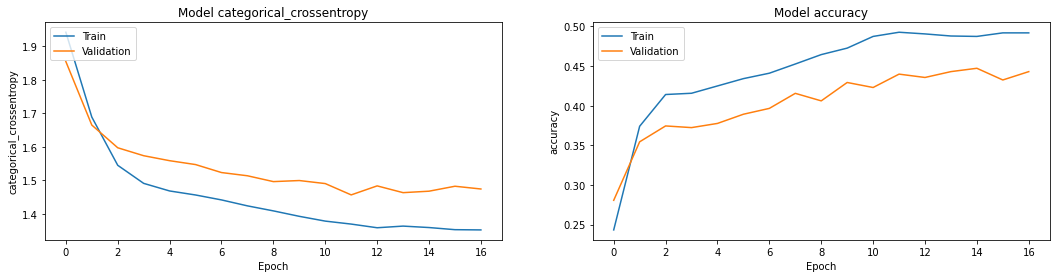

In [56]:
quick_plot_history(history)
A, B, C, D = split_channels_4(X_test)

test_results(model11, [A, B, C, D], y_test)

# Model 13

In [57]:
def go_depper(inputs, deapth=1):
    x = concatenate(inputs)
    a ,N = x.shape 
    if deapth!=0:
        x = dense_deapth_block(x, deapth=deapth, N=N)
    x = Dense(8)(x)
    return x
    
def go_all_deper(inputs, group_size=2, deapth=2):
    size = len(inputs)
    xs = []
    for i in range(size):
        if size - i - group_size >= 0:
            group = inputs[i:i+group_size]
            x = go_depper(group, deapth=deapth)
            xs.append(x)
    if len(xs) == 1:
        return xs[0]
    x = concatenate(xs)
    return x

In [58]:
def create_model_channel_4_2():
    inp1, c1 = create_chanel(deapth=2,N=32)
    inp2, c2 = create_chanel(N=32)
    inp3, c3 = create_chanel(size=2,deapth=2,N=6)
    inp4, c4 = create_chanel(size=2,deapth=2,N=6)
    
    inp5 = concatenate([inp1,inp2])
    c5 = dense_deapth_block(inp5,deapth=2,N=32)
    
    inp6 = concatenate([inp3,inp4])
    c6 = dense_deapth_block(inp6,deapth=2,N=32)
    
    x = concatenate([c1,c2, c3, c4, c5, c6])
    x = Dense(8)(x)
    x = Activation('softmax')(x)
    model = Model(inputs=[inp1, inp2, inp3, inp4], outputs=x, name='model13') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model13 = create_model_channel_4_2()
model13.summary()

Model: "model13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_21 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 32)           128         input_21[0][0]                   
__________________________________________________________________________________________________
p_re_lu_29 (PReLU)              (None, 32)           32          dense_63[0][0]                   
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 36)           1188        p_re_lu_29[0][0]                 
____________________________________________________________________________________________

In [59]:
A, B, C, D = split_channels_4(X_train)
callbacks = create_callbacks('model13.h5')
history = model13.fit([A, B, C, D], y_train, epochs=EPOCKS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=callbacks)

Epoch 1/50
119/119 [==============================] - 1s 7ms/step - loss: 1.9561 - accuracy: 0.2553 - val_loss: 1.7825 - val_accuracy: 0.3259
Epoch 2/50
119/119 [==============================] - 1s 4ms/step - loss: 1.6282 - accuracy: 0.3806 - val_loss: 1.6086 - val_accuracy: 0.3513
Epoch 3/50
119/119 [==============================] - 1s 4ms/step - loss: 1.5217 - accuracy: 0.4060 - val_loss: 1.5615 - val_accuracy: 0.3829
Epoch 4/50
119/119 [==============================] - 1s 4ms/step - loss: 1.4799 - accuracy: 0.4205 - val_loss: 1.5515 - val_accuracy: 0.3576
Epoch 5/50
119/119 [==============================] - 1s 4ms/step - loss: 1.4649 - accuracy: 0.4276 - val_loss: 1.5544 - val_accuracy: 0.3766
Epoch 6/50
119/119 [==============================] - 1s 4ms/step - loss: 1.4682 - accuracy: 0.4257 - val_loss: 1.5453 - val_accuracy: 0.3966
Epoch 7/50
119/119 [==============================] - 1s 4ms/step - loss: 1.4596 - accuracy: 0.4231 - val_loss: 1.5260 - val_accuracy: 0.4040
Epoch 

model accuracy on test set is: 51.48%


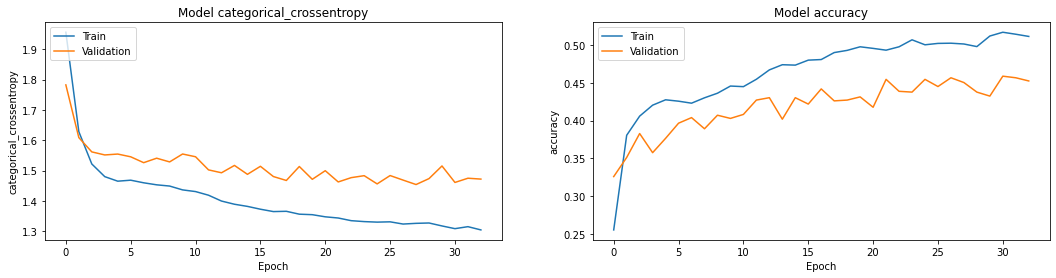

In [60]:
quick_plot_history(history)
A, B, C, D = split_channels_4(X_test)
test_results(model13, [A, B, C, D], y_test)

# Model 12

In [61]:
def split_channels_5(X):
    A = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z'], axis=1)
    B = X.drop(['accelometer_x','accelometer_y','accelometer_z'], axis=1)
    C = X.drop(['gyroscope_y','gyroscope_z','accelometer_y','accelometer_z'], axis=1)
    D = X.drop(['gyroscope_x','gyroscope_z','accelometer_x','accelometer_z'], axis=1)
    E = X.drop(['gyroscope_x','gyroscope_y','accelometer_x','accelometer_y'], axis=1)
    return A, B, C, D, E

def create_model_channel_5():
    inp1, c1 = create_chanel(deapth=2,N=32)
    inp2, c2 = create_chanel(N=32)
    inp3, c3 = create_chanel(size=2,deapth=2,N=8)
    inp4, c4 = create_chanel(size=2,deapth=2,N=8)
    inp5, c5 = create_chanel(size=2,deapth=2,N=8)
    
    
    inp6= concatenate([inp1,inp2])
    c6 = dense_deapth_block(inp6,deapth=2,N=32,extend_N=16)
    
    inp7 = concatenate([inp3,inp4])
    c7 = dense_deapth_block(inp7,deapth=2,N=8)
    
    inp8 = concatenate([inp4,inp5])
    c8 = dense_deapth_block(inp8,deapth=2,N=8)
    
    inp9 = concatenate([inp3,inp5])
    c9 = dense_deapth_block(inp9,deapth=2,N=8)
    
    x = concatenate([c1,c2, c3, c4, c5, c6, c7, c8, c9])
    x = Dense(100)(x)
    x = PReLU()(x)
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2, inp3, inp4, inp5], outputs=x, name='model12') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model12 = create_model_channel_5()

In [62]:
A, B, C, D, E = split_channels_5(X_train)
callbacks = create_callbacks('model12.h5')
history = model12.fit([A, B, C, D, E], y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/200
60/60 [==============================] - 1s 15ms/step - loss: 2.0380 - accuracy: 0.2237 - val_loss: 1.8491 - val_accuracy: 0.2627
Epoch 2/200
60/60 [==============================] - 0s 8ms/step - loss: 1.7130 - accuracy: 0.3411 - val_loss: 1.6662 - val_accuracy: 0.3333
Epoch 3/200
60/60 [==============================] - 0s 8ms/step - loss: 1.5485 - accuracy: 0.3954 - val_loss: 1.5664 - val_accuracy: 0.3776
Epoch 4/200
60/60 [==============================] - 0s 8ms/step - loss: 1.4830 - accuracy: 0.4112 - val_loss: 1.6062 - val_accuracy: 0.3544
Epoch 5/200
60/60 [==============================] - 0s 8ms/step - loss: 1.4773 - accuracy: 0.4186 - val_loss: 1.5867 - val_accuracy: 0.3534
Epoch 6/200
60/60 [==============================] - 0s 8ms/step - loss: 1.4671 - accuracy: 0.4255 - val_loss: 1.5508 - val_accuracy: 0.4040
Epoch 7/200
60/60 [==============================] - 0s 7ms/step - loss: 1.4563 - accuracy: 0.4292 - val_loss: 1.5380 - val_accuracy: 0.3903
Epoch 8/200


model accuracy on test set is: 50.13%


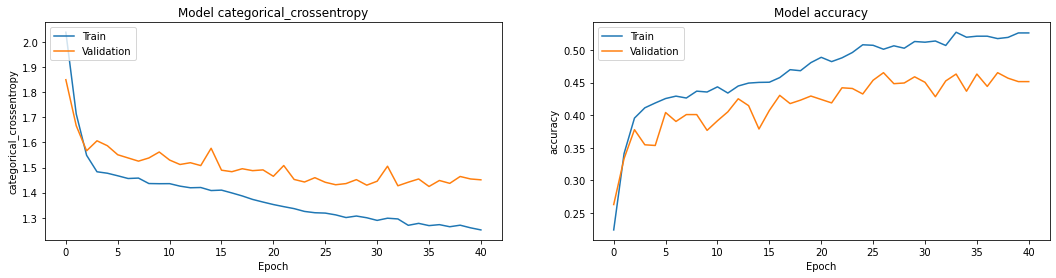

In [63]:
quick_plot_history(history)
A, B, C, D, E = split_channels_5(X_test)
test_results(model12, [A, B, C, D, E], y_test)

# Model 14

In [64]:
def create_model_channel_5_2():
    inp1, c1 = create_chanel(deapth=2,N=32)
    inp2, c2 = create_chanel(N=32)
    inp3, c3 = create_chanel(size=2,deapth=2,N=8)
    inp4, c4 = create_chanel(size=2,deapth=2,N=8)
    inp5, c5 = create_chanel(size=2,deapth=2,N=8)
    
    inp7 = concatenate([inp3,inp4])
    c7 = dense_deapth_block(inp7,deapth=2,N=8)
    
    inp8 = concatenate([inp4,inp5])
    c8 = dense_deapth_block(inp8,deapth=2,N=8)
    
    inp9 = concatenate([inp3,inp5])
    c9 = dense_deapth_block(inp9,deapth=2,N=8)
    
    x2 = concatenate([c1, c2, c3, c4, c5, c7, c8, c9])
    x2 = Dense(8)(x2)
    x2 = PReLU()(x2)
    
    x1 = concatenate([c1, c2, c3, c4, c5])
    x1 = Dense(8)(x1)
    x1 = PReLU()(x1)
    
    x0 = concatenate([c1, c2])
    x0 = Dense(8)(x0)
    x0 = PReLU()(x0)
    
    x = concatenate([x0,x1,x2])
    x = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=[inp1, inp2, inp3, inp4, inp5], outputs=x, name='model14') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model14 = create_model_channel_5_2()

In [65]:
A, B, C, D, E = split_channels_5(X_train)
callbacks = create_callbacks('model14.h5')
history = model14.fit([A, B, C, D, E], y_train, epochs=200, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/200
60/60 [==============================] - 1s 14ms/step - loss: 2.0240 - accuracy: 0.2005 - val_loss: 1.9568 - val_accuracy: 0.2743
Epoch 2/200
60/60 [==============================] - 0s 7ms/step - loss: 1.8292 - accuracy: 0.2896 - val_loss: 1.7833 - val_accuracy: 0.3333
Epoch 3/200
60/60 [==============================] - 0s 7ms/step - loss: 1.6649 - accuracy: 0.3727 - val_loss: 1.6560 - val_accuracy: 0.3745
Epoch 4/200
60/60 [==============================] - 0s 7ms/step - loss: 1.5530 - accuracy: 0.4028 - val_loss: 1.5966 - val_accuracy: 0.3861
Epoch 5/200
60/60 [==============================] - 0s 7ms/step - loss: 1.5019 - accuracy: 0.4162 - val_loss: 1.5591 - val_accuracy: 0.3829
Epoch 6/200
60/60 [==============================] - 1s 8ms/step - loss: 1.4769 - accuracy: 0.4265 - val_loss: 1.5536 - val_accuracy: 0.3871
Epoch 7/200
60/60 [==============================] - 0s 7ms/step - loss: 1.4592 - accuracy: 0.4334 - val_loss: 1.5614 - val_accuracy: 0.3576
Epoch 8/200


model accuracy on test set is: 50.72%


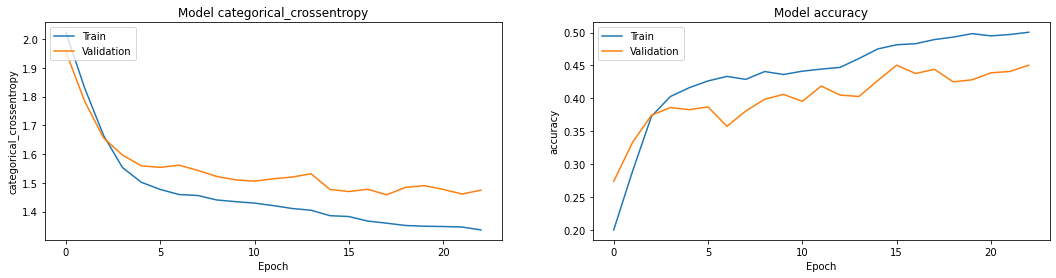

In [66]:
quick_plot_history(history)
A, B, C, D, E = split_channels_5(X_test)
test_results(model14, [A, B, C, D, E], y_test)

# Model 15

In [67]:
print(X_train_d.columns)

Index(['prev_1_accelometer_x', 'prev_1_accelometer_y', 'prev_1_accelometer_z',
       'prev_1_gyroscope_x', 'prev_1_gyroscope_y', 'prev_1_gyroscope_z',
       'accelometer_x', 'accelometer_y', 'accelometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z'],
      dtype='object')


In [68]:
def split_channels_4_d(X):
    # acc
    A = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z', 
                'sub_gyroscope_x','sub_gyroscope_y','sub_gyroscope_z', 
                'sub_accelometer_x','sub_accelometer_y','sub_accelometer_z'], axis=1)
    # gyro
    B = X.drop(['accelometer_x','accelometer_y','accelometer_z',
                'sub_gyroscope_x','sub_gyroscope_y','sub_gyroscope_z', 
                'sub_accelometer_x','sub_accelometer_y','sub_accelometer_z'], axis=1)
    # sub acc
    C = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z', 
                'sub_gyroscope_x','sub_gyroscope_y','sub_gyroscope_z', 
                'accelometer_x','accelometer_y','accelometer_z'], axis=1)
    # sub gyro
    D = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z', 
                'accelometer_x','accelometer_y','accelometer_z', 
                'sub_accelometer_x','sub_accelometer_y','sub_accelometer_z'], axis=1)
    return A, B, C, D

def create_model_channel_4_d():
    inp1, c1 = create_chanel(deapth=2,N=32)
    inp2, c2 = create_chanel(N=32)
    inp3, c3 = create_chanel(N=32)
    inp4, c4 = create_chanel(N=32)
    x = concatenate([c1, c2, c3, c4])
    x = Dense(8, activation='softmax')(x)
    model = Model(inputs=[inp1, inp2, inp3, inp4], outputs=x, name='model15') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model15 = create_model_channel_4_d()
model15.summary()

Model: "model15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_125 (Dense)               (None, 32)           128         input_35[0][0]                   
____________________________________________________________________________________________

In [71]:
A, B, C, D = split_channels_4_d(X_train_s)
#print(A)
callbacks = create_callbacks('model15.h5')
history = model15.fit([A, B, C, D], y_train_s, epochs=200, batch_size=64, validation_split=0.2, callbacks= callbacks)

Epoch 1/200
60/60 [==============================] - 0s 6ms/step - loss: 0.7598 - accuracy: 0.7189 - val_loss: 1.3845 - val_accuracy: 0.5903
Epoch 2/200
60/60 [==============================] - 0s 7ms/step - loss: 0.7572 - accuracy: 0.7268 - val_loss: 1.4182 - val_accuracy: 0.5776
Epoch 3/200
60/60 [==============================] - 0s 6ms/step - loss: 0.7321 - accuracy: 0.7316 - val_loss: 1.4070 - val_accuracy: 0.5755
Epoch 4/200
60/60 [==============================] - 0s 6ms/step - loss: 0.7277 - accuracy: 0.7308 - val_loss: 1.4093 - val_accuracy: 0.5818
Epoch 5/200
60/60 [==============================] - 0s 6ms/step - loss: 0.7399 - accuracy: 0.7321 - val_loss: 1.3917 - val_accuracy: 0.5882
Epoch 6/200
60/60 [==============================] - 0s 6ms/step - loss: 0.7289 - accuracy: 0.7313 - val_loss: 1.4186 - val_accuracy: 0.5744


model accuracy on test set is: 56.08%


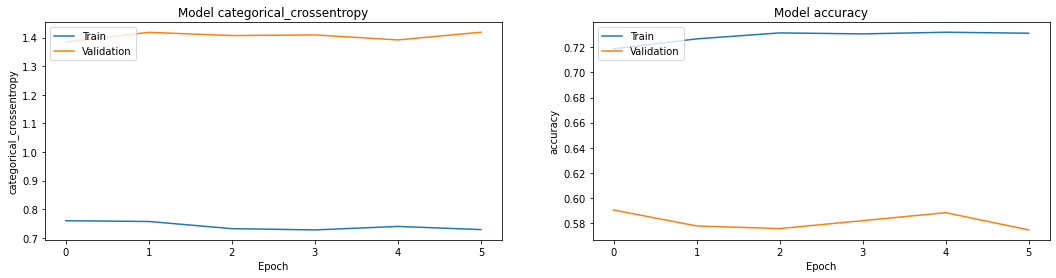

In [75]:
quick_plot_history(history)
A, B, C, D = split_channels_4_d(X_test_s)
test_results(model15, [A, B, C, D], y_test_s)

# Model 16

In [178]:
def split_train_test_by_sliding_window(X,y, N=3):
    grouped = gens.groupby('tag')
    X_tmp = None
    X_original = None
    y_original = None
    start = N
    end = None
    for g in grouped:
        X, y = create_X_y(g[1])
        end = len(X)
        tmp_dic = {}
        if X_original is None:
            X_original = X.iloc[start:]
            y_original = y.iloc[start:]
        else:
            X_original = pd.concat([X_original,X.iloc[start:]])
            y_original = pd.concat([y_original, y.iloc[start:]])
        for col in X.columns:
            for i in range(1,N,1):
                name = 'prev_'+str(i)+'_'+col
                tmp_dic[name] = X[col].iloc[start-i: end-i].values
        if X_tmp is None:
            X_tmp = pd.DataFrame.from_dict(tmp_dic)
        else:
            X_tmp = pd.concat([X_tmp, pd.DataFrame.from_dict(tmp_dic)])
    X_original = X_original.reset_index()
    X_tmp = X_tmp.reset_index()
    X_tmp = pd.concat([X_tmp, X_original], axis=1)
    X_tmp = X_tmp.drop(['index'], axis=1)
    print('X devide: ',X_tmp.shape, ' y devide: ', y_original.shape)
    X_train, X_test, y_train, y_test = split_train_test(X_tmp, y_original)
    return X_train, X_test, y_train, y_test

X_train_d, X_test_d, y_train_d, y_test_d = split_train_test_by_sliding_window(X, y)
y_train_d, y_test_d, y_dic_d = y_to_categorical(y_train_d, y_test_d)
print('nan indexes',np.where(pd.isnull(X_train_d)))

X devide:  (5900, 18)  y devide:  (5900,)
X train shape:  (4720, 18)  y train shape:  (4720,)
X test shape:  (1180, 18)  y test shape:  (1180,)
Changed to catigorical y train shape:  4720  y test shape:  1180
nan indexes (array([], dtype=int64), array([], dtype=int64))


In [179]:
print(X_train_d.columns)

Index(['prev_1_accelometer_x', 'prev_2_accelometer_x', 'prev_1_accelometer_y',
       'prev_2_accelometer_y', 'prev_1_accelometer_z', 'prev_2_accelometer_z',
       'prev_1_gyroscope_x', 'prev_2_gyroscope_x', 'prev_1_gyroscope_y',
       'prev_2_gyroscope_y', 'prev_1_gyroscope_z', 'prev_2_gyroscope_z',
       'accelometer_x', 'accelometer_y', 'accelometer_z', 'gyroscope_x',
       'gyroscope_y', 'gyroscope_z'],
      dtype='object')


In [181]:
A, B, C, D, E, F = split_channels_6_d(X_train_d)
print('A nan indexes',np.where(pd.isnull(A)))
print('B nan indexes',np.where(pd.isnull(B)))
print('C nan indexes',np.where(pd.isnull(C)))
print('D nan indexes',np.where(pd.isnull(D)))
print('E nan indexes',np.where(pd.isnull(E)))
print('F nan indexes',np.where(pd.isnull(F)))

A nan indexes (array([], dtype=int64), array([], dtype=int64))
B nan indexes (array([], dtype=int64), array([], dtype=int64))
C nan indexes (array([], dtype=int64), array([], dtype=int64))
D nan indexes (array([], dtype=int64), array([], dtype=int64))
E nan indexes (array([], dtype=int64), array([], dtype=int64))
F nan indexes (array([], dtype=int64), array([], dtype=int64))


In [147]:
def split_channels_6_d(X):
    gyro = X.drop(['accelometer_x','accelometer_y','accelometer_z',
                   'prev_1_accelometer_x','prev_1_accelometer_y','prev_1_accelometer_z',
                   'prev_2_accelometer_x','prev_2_accelometer_y','prev_2_accelometer_z',
                   'prev_1_gyroscope_x','prev_1_gyroscope_y','prev_1_gyroscope_z',
                   'prev_2_gyroscope_x','prev_2_gyroscope_y','prev_2_gyroscope_z',
                  ], axis=1)
    gyro1 = X.drop(['accelometer_x','accelometer_y','accelometer_z',
                   'prev_1_accelometer_x','prev_1_accelometer_y','prev_1_accelometer_z',
                   'prev_2_accelometer_x','prev_2_accelometer_y','prev_2_accelometer_z',
                   'gyroscope_x','gyroscope_y','gyroscope_z',
                   'prev_2_gyroscope_x','prev_2_gyroscope_y','prev_2_gyroscope_z',
                  ], axis=1)
    gyro2 = X.drop(['accelometer_x','accelometer_y','accelometer_z',
                   'prev_1_accelometer_x','prev_1_accelometer_y','prev_1_accelometer_z',
                   'prev_2_accelometer_x','prev_2_accelometer_y','prev_2_accelometer_z',
                   'prev_1_gyroscope_x','prev_1_gyroscope_y','prev_1_gyroscope_z',
                   'gyroscope_x','gyroscope_y','gyroscope_z',
                  ], axis=1)
    acc = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z',
                   'prev_1_accelometer_x','prev_1_accelometer_y','prev_1_accelometer_z',
                   'prev_2_accelometer_x','prev_2_accelometer_y','prev_2_accelometer_z',
                   'prev_1_gyroscope_x','prev_1_gyroscope_y','prev_1_gyroscope_z',
                   'prev_2_gyroscope_x','prev_2_gyroscope_y','prev_2_gyroscope_z',
                  ], axis=1)
    acc1 = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z',
                   'accelometer_x','accelometer_y','accelometer_z',
                   'prev_2_accelometer_x','prev_2_accelometer_y','prev_2_accelometer_z',
                   'prev_1_gyroscope_x','prev_1_gyroscope_y','prev_1_gyroscope_z',
                   'prev_2_gyroscope_x','prev_2_gyroscope_y','prev_2_gyroscope_z',
                  ], axis=1)
    acc2 = X.drop(['gyroscope_x','gyroscope_y','gyroscope_z',
                   'accelometer_x','accelometer_y','accelometer_z',
                   'prev_1_accelometer_x','prev_1_accelometer_y','prev_1_accelometer_z',
                   'prev_1_gyroscope_x','prev_1_gyroscope_y','prev_1_gyroscope_z',
                   'prev_2_gyroscope_x','prev_2_gyroscope_y','prev_2_gyroscope_z',
                  ], axis=1)
    return acc, gyro, acc1, gyro1, acc2, gyro2

In [197]:
def create_model_channel_6_d():
    inp1, c1 = create_chanel(deapth=2,N=32)
    inp2, c2 = create_chanel(N=32)
    inp3, c3 = create_chanel(deapth=2,N=32)
    inp4, c4 = create_chanel(N=32)
    inp5, c5 = create_chanel(deapth=2,N=32)
    inp6, c6 = create_chanel(N=32)
    x = concatenate([c1, c2, c3, c4, c5, c6])
    x = Dense(8, activation='softmax')(x)
    
    model = Model(inputs=[inp1, inp2, inp3, inp4, inp5, inp6], outputs=x, name='model16') 
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=create_metrics())
    return model

model16 = create_model_channel_6_d()
model16.summary()

Model: "model16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_189 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_191 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
input_193 (InputLayer)          [(None, 3)]          0                                            
__________________________________________________________________________________________________
dense_707 (Dense)               (None, 32)           128         input_189[0][0]                  
____________________________________________________________________________________________

In [199]:
A, B, C, D, E, F = split_channels_6_d(X_train_d)
callbacks = create_callbacks('model16.h5')
history = model16.fit([A, B, C, D, E, F], y_train_d, epochs=200, batch_size=64, validation_split=0.2, callbacks=callbacks)

Epoch 1/200
59/59 [==============================] - 1s 16ms/step - loss: 2.0370 - accuracy: 0.1954 - val_loss: 1.9072 - val_accuracy: 0.2447
Epoch 2/200
59/59 [==============================] - 0s 8ms/step - loss: 1.8419 - accuracy: 0.2810 - val_loss: 1.7987 - val_accuracy: 0.3305
Epoch 3/200
59/59 [==============================] - 0s 8ms/step - loss: 1.7254 - accuracy: 0.3541 - val_loss: 1.6663 - val_accuracy: 0.4004
Epoch 4/200
59/59 [==============================] - 0s 8ms/step - loss: 1.5745 - accuracy: 0.4261 - val_loss: 1.5443 - val_accuracy: 0.4216
Epoch 5/200
59/59 [==============================] - 0s 8ms/step - loss: 1.4234 - accuracy: 0.4860 - val_loss: 1.3840 - val_accuracy: 0.4788
Epoch 6/200
59/59 [==============================] - 0s 8ms/step - loss: 1.3072 - accuracy: 0.5257 - val_loss: 1.2926 - val_accuracy: 0.5127
Epoch 7/200
59/59 [==============================] - 1s 9ms/step - loss: 1.2318 - accuracy: 0.5381 - val_loss: 1.2497 - val_accuracy: 0.5138
Epoch 8/200


model accuracy on test set is: 63.22%


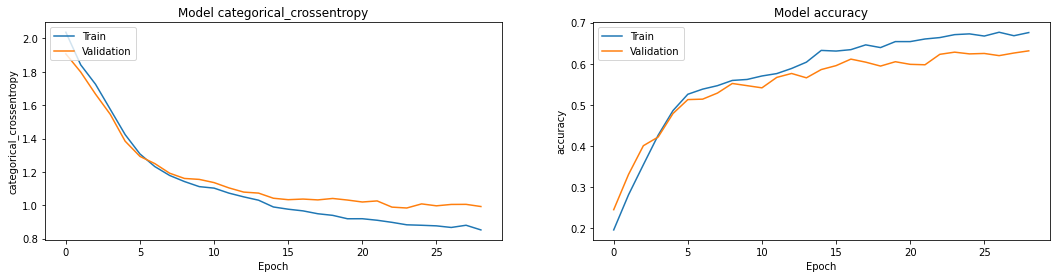

In [200]:
quick_plot_history(history)
A, B, C, D, E, F = split_channels_6_d(X_test_d)
test_results(model16, [A, B, C, D, E, F], y_test_d)

# Model 17

# Regression Problem

In [ ]:
def tag_to_vector(tag):
    vx = 5
    vy = 5
    if tag == 'up': 
        return [0, vy]
    elif tag == 'down':
        return [0, -vy]
    elif tag == 'right':
        return [vx, 0]
    elif tag == 'left':
        return [-vx, 0]
    elif tag == 'upright':
        return [vx, vy]
    elif tag == 'downleft':
        return [-vx, -vy]
    elif tag == 'upleft':
        return [-vx, vy]
    #elif tag =='downright'
    return [vx, -vy]

def y_to_vector_speed(y_train, y_test):
    y_train = [tag_to_vector(x) for x in y_train]
    y_test = [tag_to_vector(x) for x in y_test]
    y_train = y_train.to_numpy()
    print('Changed to vector','y train shape: ',len(y_train), ' y test shape: ', len(y_test))
    return y_train, y_test
    
X_train, X_test, y_train, y_test = split_train_test(X, y)
y_train, y_test = y_to_vector_speed(y_train, y_test)